### Inference of CNN Onset Detection

In [1]:
import sys
import glob
import torch
from torch.utils import data
from utils import onsetCNN, Dataset
import numpy as np
import matplotlib.pyplot as plt
import os
import utils

import librosa

# dangerous solution
os.environ['KMP_DUPLICATE_LIB_OK']='True' 


Load Song, Calculate Mean and STD of Song

In [3]:
audio_name = 'castanet'
audio_format = '.wav'
save_dir = './data_pt_inference'

means_song=[np.array([]),np.array([]),np.array([])]
stds_song=[np.array([]),np.array([]),np.array([])]


#load audio
x,fs=librosa.load(audio_name+audio_format, sr=44100)

#get mel spectrogram

#updated to melspectrogram new librosa syntax
melgram1=librosa.feature.melspectrogram(y=x,sr=fs,n_fft=1024, hop_length=441,n_mels=80, fmin=27.5, fmax=16000)
melgram2=librosa.feature.melspectrogram(y=x,sr=fs,n_fft=2048, hop_length=441,n_mels=80, fmin=27.5, fmax=16000)
melgram3=librosa.feature.melspectrogram(y=x,sr=fs,n_fft=4096, hop_length=441,n_mels=80, fmin=27.5, fmax=16000)

#log scaling
melgram1=10*np.log10(1e-10+melgram1)
melgram2=10*np.log10(1e-10+melgram2)
melgram3=10*np.log10(1e-10+melgram3)

means_song[0]=np.mean(melgram1,1)
means_song[1]=np.mean(melgram2,1)
means_song[2]=np.mean(melgram3,1)

stds_song[0]=np.std(melgram1,1)
stds_song[1]=np.std(melgram2,1)
stds_song[2]=np.std(melgram3,1)


# prepare for data generation
means = means_song
stds = stds_song

Gen Data

In [7]:


#function to zero pad ends of spectrogram
def zeropad2d(x,n_frames):
	y=np.hstack((np.zeros([x.shape[0],n_frames]), x))
	y=np.hstack((y,np.zeros([x.shape[0],n_frames])))
	return y

#function to create N-frame overlapping chunks of the full audio spectrogram  
def makechunks(x,duration):
	y=np.zeros([x.shape[1],x.shape[0],duration])
	for i_frame in range(x.shape[1]-duration):
		y[i_frame]=x[:,i_frame:i_frame+duration]
	return y
#context parameters
contextlen=7 #+- frames
duration=2*contextlen+1

#main
songlist=np.loadtxt('songlist.txt',dtype=str)
audio_format='.flac'
labels_master={}
weights_master={}
filelist=[]

#normalize
melgram1=(melgram1-np.atleast_2d(means[0]).T)/np.atleast_2d(stds[0]).T
melgram2=(melgram2-np.atleast_2d(means[1]).T)/np.atleast_2d(stds[1]).T
melgram3=(melgram3-np.atleast_2d(means[2]).T)/np.atleast_2d(stds[2]).T

#zero pad ends
melgram1=zeropad2d(melgram1,contextlen)
melgram2=zeropad2d(melgram2,contextlen)
melgram3=zeropad2d(melgram3,contextlen)

#make chunks
melgram1_chunks=makechunks(melgram1,duration)
melgram2_chunks=makechunks(melgram2,duration)
melgram3_chunks=makechunks(melgram3,duration)

# #generate song labels
# hop_dur=10e-3
# labels=np.zeros(melgram1_chunks.shape[0])
# weights=np.ones(melgram1_chunks.shape[0])
# idxs=np.array(np.round(onsets/hop_dur),dtype=int)
# labels[idxs]=1

# #target smearing
# labels[idxs-1]=1
# labels[idxs+1]=1
# weights[idxs-1]=0.25
# weights[idxs+1]=0.25

# labels_dict={}
# weights_dict={}

for i_chunk in range(melgram1_chunks.shape[0]):
    savepath = os.path.join(save_dir,str(i_chunk)+'.pt')
    #np.save(savepath,np.array([melgram1_chunks[i_chunk],melgram2_chunks[i_chunk],melgram3_chunks[i_chunk]]))
    torch.save(torch.tensor(np.array([melgram1_chunks[i_chunk], melgram2_chunks[i_chunk], melgram3_chunks[i_chunk]])), savepath)


Load Model

In [2]:
#Use gpu
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

#evaluation tolerance and merge duration for close onsets
tolerance=60e-3 #+- tolerance/2 seconds
mergeDur=20e-3
hop_dur=10e-3
mergeDur_frame=mergeDur/hop_dur
tolerance_frame=tolerance/hop_dur

# fold = int(sys.argv[1]) #cmd line argument

#load model
path_to_saved_model = 'models/saved_model_0.pt'
model = onsetCNN().double().to(device)
model.load_state_dict(torch.load(path_to_saved_model,map_location='cuda:0'))
model.eval()

onsetCNN(
  (conv1): Conv2d(3, 10, kernel_size=(3, 7), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1120, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=1, bias=True)
  (dout): Dropout(p=0.5, inplace=False)
)

In [34]:
save_dir = './data_pt_inference'

odf=np.array([])

n_files=len(glob.glob('./data_pt_inference/*.pt'))
for i_file in range(n_files):
    x=torch.load(os.path.join(save_dir,'%d.pt'%i_file)).to(device)
    x=x.unsqueeze(0)
    y=model(x).squeeze().cpu().detach().numpy()
    odf=np.append(odf,y)
    

In [35]:
print('device: ', device)
print(len(odf))

device:  cuda:0
2057
2057


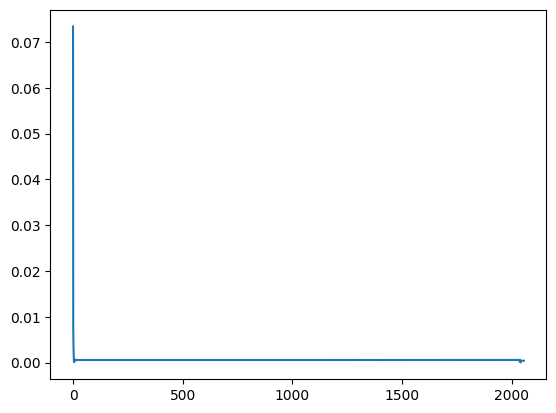

In [36]:
plt.plot(odf)